This project is aimed to create an sophisticated ML algorithm using logistic regression to categorise pyaments to detect whetehr they are fraudulent or not.

Throuhgout this project I will be showcasing learnt techniques to load the data in the form of CSV
Using EDA to critically analyse the data and decide on features and eploit any bias or variance within the dataset.
Then using Schikit-learn to preprocess and split the data.
Fitting the model and the tetsing and evaluating the model to ensure the highest accuracy is achieved whilst maintaining a good balance of not over/underfitting.

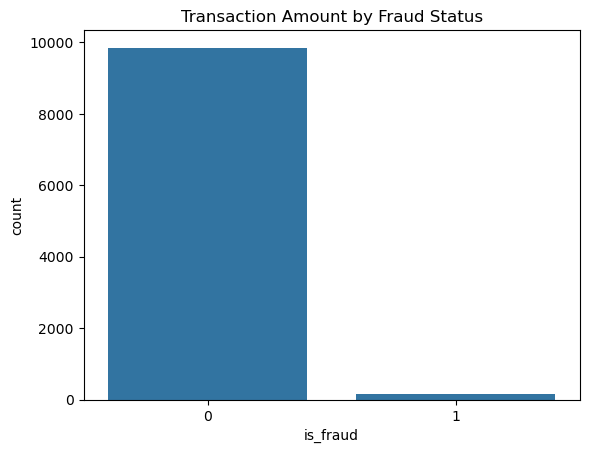

In [15]:
#Importing relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

#Loading the dataset
transaction_data = pd.read_csv('credit_card_fraud_10k.csv')

#Exploring the dataset#print(transaction_data.head())
#print(transaction_data.info())
#print(transaction_data.describe())
#print(transaction_data.isnull().sum())
#print(transaction_data['is_fraud'].value_counts())

#print(transaction_data.corr(numeric_only=True)['is_fraud'].sort_values(ascending=False))



sns.countplot(x='is_fraud',data=transaction_data)
plt.title('Transaction Amount by Fraud Status')
plt.show()

Upon loading and inspecting the data I can see that the imbalance of fraud to not fraud is around 1.5% Fraud this shows a realistic example of real world bamking data which hold quite low statistics on detected fraud as it is not as often. I can aslo see healthy correlations between the features and target 'is_fraud'. This sets me up nicely to start splitting the data and starting the pipeline but will need to implement class balancing.

In [20]:
X = transaction_data.drop('is_fraud', axis=1)
y = transaction_data['is_fraud']

#Analysing X
#print(X.dtypes)
#print(X.isnull().sum())

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



#Identifying numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

#Pipeline for numeric features
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
#Pipeline for categorical features
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
#Combining the preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
    ])
#Creating a pipeline with preprocessor and classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

#Fit the model with the training data

model.fit(X_train, y_train)







Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['transaction_id', 'amount', 'transaction_hour', 'foreign_transaction',
       'location_mismatch', 'device_trust_score', 'velocity_last_24h',
       'cardholder_age'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['merchant_category'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

I have split my data into training and testing sets which i have fit the training data to a random forest classifier to help reduce overfitiing and create a average of the results to hopefully get a more accurate predictions. I will now carry out some evaluation techniques to test the model efficiency.

Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1970
           1       0.60      1.00      0.75        30

    accuracy                           0.99      2000
   macro avg       0.80      0.99      0.87      2000
weighted avg       0.99      0.99      0.99      2000

1.0
Threshold: 0.2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1970
           1       1.00      0.97      0.98        30

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000

1.0
Threshold: 0.25
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1970
           1       1.00      0.97      0.98        30

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1

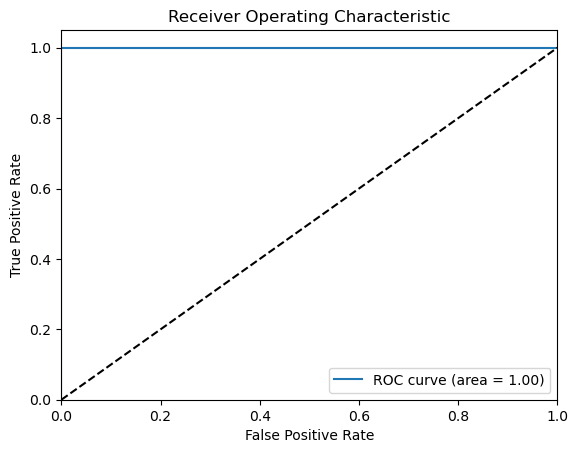

In [ ]:
#Created predictions and probabilities for the test set to adjust the threshold for classification if needed
y_proba = model.predict_proba(X_test)[:, 1]
#y_pred = (y_proba >= 0.5).astype(int)

# Evaluation tecniques 

#print(classification_report(y_test, y_pred))

# Confusion matrix - TP, FP, TN, FN

#print(confusion_matrix(y_test, y_pred))

# ROC AUC Score
#roc_auc = roc_auc_score(y_test, y_proba)
#print(f"ROC AUC Score: {roc_auc}")

thresholds = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred_optimisation = (y_proba >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred_optimisation))
    print(roc_auc_score(y_test, y_proba))




#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




Out of carrying out multiple tests above using a test datset from online I achieved alomost perfect detection. With the data being so imbalanced with 98.5% non-fraud and 1.5% fraud I used a small loop to iterate through a list tuning the classification threshold to try and maximise the recall and precision for the model. Acieving 0.97 rceall on the fraud detection meaning it missed very little fraud cases (3%) and precison of 100% meaning that all that were predicted were actually fraud. Of course this is an online training set and the data might not be as easy to train the model but after doing furtehr tests below which shows no one feature was purely dominannt showing that it was just 'easy' data.

In [27]:
feature_importances = model.named_steps["classifier"].feature_importances_
print(feature_importances)

[0.03567435 0.04077009 0.23693955 0.11961515 0.11656096 0.26270437
 0.13186636 0.03090173 0.0041614  0.00637375 0.00318957 0.00529635
 0.00594638]
